# Pytorch tutorial

In [115]:
%matplotlib inline  
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn

## Tensors
Tensors are similar to NumPy’s ndarrays, with the addition being that
Tensors can also be used on a GPU to accelerate computing. 

In [116]:
# Construct a 5x3 matrix, uninitialized:

x = torch.empty(5, 3)
print(x)

tensor([[                                 0.0000,
                                         -0.0000,
         -106674995352775235685935520677888.0000],
        [             -36902460162301755392.0000,
                                             nan,
                                         -0.0000],
        [                                 0.0000,
                                         12.3243,
                                          0.0000],
        [                             12558.3008,
                                        720.8165,
                                          0.0000],
        [                                12.3909,
                                          0.0000,
                                          0.0000]])


In [117]:
# Construct a randomly initialized matrix:

x = torch.rand(5, 3)
print(x)

tensor([[0.6750, 0.6137, 0.5580],
        [0.2886, 0.8135, 0.0778],
        [0.4272, 0.6638, 0.9349],
        [0.4886, 0.4339, 0.9876],
        [0.5942, 0.2862, 0.0857]])


In [118]:
# Matrix multiplication
y = torch.rand(3,5)
prod = torch.matmul(x,y)
print(prod)

tensor([[0.8397, 0.2488, 0.7560, 1.3827, 0.9409],
        [0.7387, 0.1235, 0.6391, 0.9267, 0.7718],
        [0.8948, 0.3394, 0.9645, 1.5212, 1.1881],
        [0.7530, 0.3318, 0.8292, 1.4143, 1.0320],
        [0.4383, 0.0856, 0.2820, 0.7159, 0.3624]])


In [119]:
# Construct a tensor directly from data:

x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


In [120]:
# check a tensor shape

x.shape

torch.Size([2])

## Autograd: Automatic Differentiation


Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



Create a tensor and set ``requires_grad=True`` to track computation with it

In [121]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation

In [122]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.


In [123]:
print(y.grad_fn)


Do more operations on ``y``

In [124]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>) tensor(27., grad_fn=<MeanBackward1>)


## Gradients

Let's backprop now.
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1.))``.

In [125]:
out.backward()

Print gradients $\partial_x out$

In [127]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.

## Data

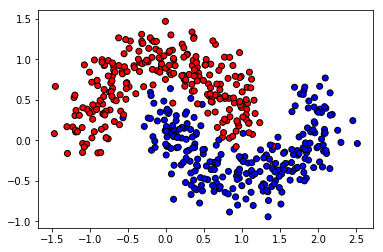

In [128]:
X, y = make_moons(n_samples = 500, noise = 0.2, random_state = 101)

# visualisation
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)

## Neural Networks


Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

### Define the network


Let’s define this network:



In [106]:
class ANN(nn.Module):
    
    def __init__(self, n_hidden):
        super(ANN, self).__init__()
        self.i_h = nn.Sequential(nn.Linear(2, n_hidden), nn.Sigmoid())
        self.h_o = nn.Sequential(nn.Linear(n_hidden, 1), nn.Sigmoid())
        
    def forward(self, x):
        h = self.i_h(x)
        output = self.h_o(h)
        return output
    
n_hidden = 30
net = ANN(n_hidden = n_hidden)
print(net)

ANN(
  (i_h): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (h_o): Sequential(
    (0): Linear(in_features=30, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()`` or by ``net.state_dict()``



In [107]:
print(net.state_dict())

OrderedDict([('i_h.0.weight', tensor([[ 0.0640, -0.4755],
        [ 0.1873, -0.6547],
        [-0.3451,  0.4537],
        [-0.3845,  0.3900],
        [-0.6510, -0.2498],
        [-0.5761, -0.2290],
        [-0.2255,  0.6331],
        [-0.1590, -0.5166],
        [ 0.3762, -0.5813],
        [-0.3063,  0.0641],
        [ 0.6840, -0.6848],
        [ 0.1247, -0.0606],
        [-0.4464, -0.4632],
        [ 0.0424, -0.3701],
        [-0.3913, -0.5105],
        [ 0.2733, -0.6209],
        [ 0.6926,  0.1282],
        [ 0.5814,  0.2177],
        [-0.4852,  0.0080],
        [ 0.0271, -0.2357],
        [-0.4405, -0.2533],
        [ 0.3362,  0.3543],
        [ 0.1560,  0.0305],
        [ 0.6195,  0.3790],
        [ 0.2778, -0.4610],
        [ 0.5129,  0.4141],
        [-0.7028,  0.0997],
        [ 0.5380, -0.1130],
        [ 0.4855,  0.3107],
        [-0.5472,  0.4711]])), ('i_h.0.bias', tensor([-0.6091, -0.4271, -0.0989,  0.6132, -0.1197, -0.0975,  0.3723, -0.6182,
        -0.4677, -0.2285, -0.405

Before proceeding further, let's recap all the classes we’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <https://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.BCELoss`` which computes the log-likelihood of the data assuming it's sampled from a Bernouilli distribution.

For example:

In [129]:
# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
target = torch.tensor(y, dtype=torch.float32).view(-1,1)

y_output = net(X_tensor)
loss_fn = nn.BCELoss(reduction="sum")
loss = loss_fn(y_output, target)
print(loss)



tensor(34.7723, grad_fn=<BinaryCrossEntropyBackward>)


Let's start follwing ``loss`` in the backward direction in its graph to see which functions created it.

In [130]:
print(loss.grad_fn)  # BCELoss
print(loss.grad_fn.next_functions[0][0])  # Sigmoid
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # Linear

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at the network's parameters




In [131]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('grad of parameters of network before backward')
for param in net.parameters():
    print(param.grad)

loss.backward()
print('grad of parameters of network after backward')
for param in net.parameters():
    print(param.grad)




grad of parameters of network before backward
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0.])
grad of parameters of network after backward
tensor([[ 0.0111,  0.0115],
        [-0.0078,  0.0189],
        [-0.0084,  0.0

### Update the weights
Recall that the optimisation of the loss function using Stochastic Gradient Descent is performed as follows:
- Initialise $W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}$.
- While Not convergence:
    - Calculate $J(\theta)$
    - Update $W^{[i]} := W^{[i]} - \alpha \cdot \partial_{W^{[i]}}J$
    - Update $b^{[i]} := b^{[i]} - \alpha \cdot \partial_{b^{[i]}}J$
    
However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
Pytorch has the package ``torch.optim`` that
implements all these methods. Using it is very simple:



In [111]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.)
print('Value of parameters of network before optimizer step:')
for param in net.parameters():
    print(param)



Value of parameters of network before optimizer step:
Parameter containing:
tensor([[ 0.0640, -0.4755],
        [ 0.1873, -0.6547],
        [-0.3451,  0.4537],
        [-0.3845,  0.3900],
        [-0.6510, -0.2498],
        [-0.5761, -0.2290],
        [-0.2255,  0.6331],
        [-0.1590, -0.5166],
        [ 0.3762, -0.5813],
        [-0.3063,  0.0641],
        [ 0.6840, -0.6848],
        [ 0.1247, -0.0606],
        [-0.4464, -0.4632],
        [ 0.0424, -0.3701],
        [-0.3913, -0.5105],
        [ 0.2733, -0.6209],
        [ 0.6926,  0.1282],
        [ 0.5814,  0.2177],
        [-0.4852,  0.0080],
        [ 0.0271, -0.2357],
        [-0.4405, -0.2533],
        [ 0.3362,  0.3543],
        [ 0.1560,  0.0305],
        [ 0.6195,  0.3790],
        [ 0.2778, -0.4610],
        [ 0.5129,  0.4141],
        [-0.7028,  0.0997],
        [ 0.5380, -0.1130],
        [ 0.4855,  0.3107],
        [-0.5472,  0.4711]], requires_grad=True)
Parameter containing:
tensor([-0.6091, -0.4271, -0.0989,  0.613

In [112]:
print('Value of parameters of network after optimizer step: ')
for param in net.parameters():
    print(param)

optimizer.step()

Value of parameters of network after optimizer step: 
Parameter containing:
tensor([[ 0.0640, -0.4755],
        [ 0.1873, -0.6547],
        [-0.3451,  0.4537],
        [-0.3845,  0.3900],
        [-0.6510, -0.2498],
        [-0.5761, -0.2290],
        [-0.2255,  0.6331],
        [-0.1590, -0.5166],
        [ 0.3762, -0.5813],
        [-0.3063,  0.0641],
        [ 0.6840, -0.6848],
        [ 0.1247, -0.0606],
        [-0.4464, -0.4632],
        [ 0.0424, -0.3701],
        [-0.3913, -0.5105],
        [ 0.2733, -0.6209],
        [ 0.6926,  0.1282],
        [ 0.5814,  0.2177],
        [-0.4852,  0.0080],
        [ 0.0271, -0.2357],
        [-0.4405, -0.2533],
        [ 0.3362,  0.3543],
        [ 0.1560,  0.0305],
        [ 0.6195,  0.3790],
        [ 0.2778, -0.4610],
        [ 0.5129,  0.4141],
        [-0.7028,  0.0997],
        [ 0.5380, -0.1130],
        [ 0.4855,  0.3107],
        [-0.5472,  0.4711]], requires_grad=True)
Parameter containing:
tensor([-0.6091, -0.4271, -0.0989,  0.613

### Let's put everything together

In [133]:
class ANN(nn.Module):
    
    def __init__(self, n_hidden):
        super(ANN, self).__init__()
        self.i_h = nn.Sequential(nn.Linear(2, n_hidden), nn.Sigmoid())
        self.h_o = nn.Sequential(nn.Linear(n_hidden, 1), nn.Sigmoid())
        
    def forward(self, x):
        h = self.i_h(x)
        output = self.h_o(h)
        return output


n_hidden = 30
net = ANN(n_hidden = n_hidden)

# optimizer
lr = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

# loss function
loss_fn = torch.nn.BCELoss(reduction="sum")

# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

# training
n_epochs = 10000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = net(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch%10 == 0:
        print("Iteration {}/{}, loss {:.4f}".format(epoch, n_epochs, loss.item()))

Iteration 0/10000, loss 361.6473
Iteration 10/10000, loss 276.4420
Iteration 20/10000, loss 236.0718
Iteration 30/10000, loss 210.6140
Iteration 40/10000, loss 194.1285
Iteration 50/10000, loss 182.7515
Iteration 60/10000, loss 174.3373
Iteration 70/10000, loss 167.7687
Iteration 80/10000, loss 162.4606
Iteration 90/10000, loss 158.0910
Iteration 100/10000, loss 154.4660
Iteration 110/10000, loss 151.4543
Iteration 120/10000, loss 148.9569
Iteration 130/10000, loss 146.8921
Iteration 140/10000, loss 145.1896
Iteration 150/10000, loss 143.7891
Iteration 160/10000, loss 142.6381
Iteration 170/10000, loss 141.6922
Iteration 180/10000, loss 140.9145
Iteration 190/10000, loss 140.2742
Iteration 200/10000, loss 139.7462
Iteration 210/10000, loss 139.3097
Iteration 220/10000, loss 138.9482
Iteration 230/10000, loss 138.6477
Iteration 240/10000, loss 138.3977
Iteration 250/10000, loss 138.1888
Iteration 260/10000, loss 138.0141
Iteration 270/10000, loss 137.8671
Iteration 280/10000, loss 137.7

Iteration 2440/10000, loss 87.4344
Iteration 2450/10000, loss 86.8063
Iteration 2460/10000, loss 86.1874
Iteration 2470/10000, loss 85.5778
Iteration 2480/10000, loss 84.9775
Iteration 2490/10000, loss 84.3863
Iteration 2500/10000, loss 83.8041
Iteration 2510/10000, loss 83.2310
Iteration 2520/10000, loss 82.6670
Iteration 2530/10000, loss 82.1119
Iteration 2540/10000, loss 81.5655
Iteration 2550/10000, loss 81.0279
Iteration 2560/10000, loss 80.4989
Iteration 2570/10000, loss 79.9785
Iteration 2580/10000, loss 79.4665
Iteration 2590/10000, loss 78.9629
Iteration 2600/10000, loss 78.4673
Iteration 2610/10000, loss 77.9800
Iteration 2620/10000, loss 77.5006
Iteration 2630/10000, loss 77.0291
Iteration 2640/10000, loss 76.5653
Iteration 2650/10000, loss 76.1090
Iteration 2660/10000, loss 75.6604
Iteration 2670/10000, loss 75.2190
Iteration 2680/10000, loss 74.7848
Iteration 2690/10000, loss 74.3579
Iteration 2700/10000, loss 73.9379
Iteration 2710/10000, loss 73.5247
Iteration 2720/10000

Iteration 5190/10000, loss 42.6797
Iteration 5200/10000, loss 42.6449
Iteration 5210/10000, loss 42.6103
Iteration 5220/10000, loss 42.5759
Iteration 5230/10000, loss 42.5417
Iteration 5240/10000, loss 42.5078
Iteration 5250/10000, loss 42.4741
Iteration 5260/10000, loss 42.4405
Iteration 5270/10000, loss 42.4072
Iteration 5280/10000, loss 42.3740
Iteration 5290/10000, loss 42.3411
Iteration 5300/10000, loss 42.3084
Iteration 5310/10000, loss 42.2759
Iteration 5320/10000, loss 42.2436
Iteration 5330/10000, loss 42.2115
Iteration 5340/10000, loss 42.1796
Iteration 5350/10000, loss 42.1478
Iteration 5360/10000, loss 42.1163
Iteration 5370/10000, loss 42.0849
Iteration 5380/10000, loss 42.0538
Iteration 5390/10000, loss 42.0228
Iteration 5400/10000, loss 41.9920
Iteration 5410/10000, loss 41.9615
Iteration 5420/10000, loss 41.9311
Iteration 5430/10000, loss 41.9008
Iteration 5440/10000, loss 41.8708
Iteration 5450/10000, loss 41.8409
Iteration 5460/10000, loss 41.8112
Iteration 5470/10000

Iteration 7640/10000, loss 37.9515
Iteration 7650/10000, loss 37.9411
Iteration 7660/10000, loss 37.9307
Iteration 7670/10000, loss 37.9203
Iteration 7680/10000, loss 37.9099
Iteration 7690/10000, loss 37.8997
Iteration 7700/10000, loss 37.8894
Iteration 7710/10000, loss 37.8792
Iteration 7720/10000, loss 37.8690
Iteration 7730/10000, loss 37.8588
Iteration 7740/10000, loss 37.8487
Iteration 7750/10000, loss 37.8386
Iteration 7760/10000, loss 37.8286
Iteration 7770/10000, loss 37.8186
Iteration 7780/10000, loss 37.8086
Iteration 7790/10000, loss 37.7987
Iteration 7800/10000, loss 37.7888
Iteration 7810/10000, loss 37.7790
Iteration 7820/10000, loss 37.7691
Iteration 7830/10000, loss 37.7594
Iteration 7840/10000, loss 37.7496
Iteration 7850/10000, loss 37.7399
Iteration 7860/10000, loss 37.7302
Iteration 7870/10000, loss 37.7206
Iteration 7880/10000, loss 37.7110
Iteration 7890/10000, loss 37.7014
Iteration 7900/10000, loss 37.6919
Iteration 7910/10000, loss 37.6824
Iteration 7920/10000

... and we plot the result

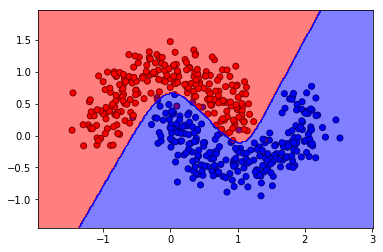

In [114]:
# plotting
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xx_tensor, yy_tensor = torch.tensor(xx, dtype=torch.float), torch.tensor(yy, dtype=torch.float)
Z = net(torch.stack([xx_tensor.flatten(), yy_tensor.flatten()], 1))
Z = Z.detach().numpy()
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)